# 2. Unzip the Data

In [ ]:
# import zipfile
# import os

# zip_path = "Shop_DataSet.zip"
# extract_path = "data/raw_data"

# os.makedirs(extract_path, exist_ok=True)
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: data/raw_data


In [ ]:
# Connect to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change directory
import os
os.chdir('/content/drive/MyDrive/Cellula/03_Project3')

# 3. Check Folders

In [ ]:
import os

for root, dirs, files in os.walk("data/raw_data"):
    level = root.replace("data/raw_data", "").count(os.sep)
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:5]:  # first 5 files preview
        print(f"{subindent}{f}")

raw_data/
    non shop lifters/
        shop_lifter_n_1_1.mp4
        shop_lifter_n_150.mp4
        shop_lifter_n_150_1.mp4
        shop_lifter_n_15.mp4
        shop_lifter_n_15_1.mp4
    shop lifters/
        shop_lifter_101.mp4
        shop_lifter_100.mp4
        shop_lifter_105.mp4
        shop_lifter_10.mp4
        shop_lifter_1.mp4


# **0. Setup & Dependencies**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import box
import plotly.express as px
import gdown
from pathlib import Path
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from rich.console import Console
from rich.panel import Panel
import torchvision.models as models
import shutil
import optuna
import gc


console = Console()

# **1. Configuration & Paths**

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Cellula/03_Project3/data/raw_data"
OUTPUT_DIR = "/content/drive/MyDrive/Cellula/03_Project3/Output"
FRAME_DIR = os.path.join(OUTPUT_DIR, "sample_frames")
CLASSES = ["non shop lifters", "shop lifters"]

CLIP_DIR = os.path.join(OUTPUT_DIR, "clips")
NPZ_DIR = os.path.join(OUTPUT_DIR, "npz")

# --- Remove and recreate directories ---
for folder in [CLIP_DIR, NPZ_DIR]:
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete the folder and its contents
    os.makedirs(folder, exist_ok=True)

# --- Ensure frame directory exists (no delete) ---
os.makedirs(FRAME_DIR, exist_ok=True)

# **2. Dataset Analysis Utilities**

## **2.1 Count & summarize videos**

In [ ]:
def get_video_files(data_dir):
    """Find all video files by class and print summary."""
    video_dict = {}
    for class_name in CLASSES:
        class_path = os.path.join(data_dir, class_name)
        videos = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        video_dict[class_name] = videos

    table = Table(title="🎥 Videos Found Per Class", box=box.ROUNDED, style="cyan")
    table.add_column("Class", style="magenta", justify="center")
    table.add_column("Count", style="green", justify="center")
    for k, v in video_dict.items():
        table.add_row(k, str(len(v)))
    console.print(table)
    return video_dict

In [ ]:
def get_video_stats(video_path):
    """Extract metadata for a single video file."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    duration = frames / fps
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    size_mb = os.path.getsize(video_path) / (1024*1024)
    return {"frames": frames, "fps": fps, "duration": duration,
            "width": width, "height": height, "size_mb": size_mb}

In [ ]:
def analyze_dataset(video_dict):
    """Analyze all videos and print dataset summary."""
    records = []
    for label, videos in video_dict.items():
        for v in videos:
            stats = get_video_stats(v)
            if stats:
                stats["class"] = label
                stats["file"] = os.path.basename(v)
                records.append(stats)
    df = pd.DataFrame(records)

    summary = df.groupby("class").agg(
        videos=("file", "count"),
        avg_duration=("duration", "mean"),
        avg_frames=("frames", "mean"),
        avg_size=("size_mb", "mean"),
        resolution=("width", lambda x: f"{int(np.mean(x))}x{int(np.mean(df['height']))}")
    ).reset_index()

    table = Table(title="📊 Dataset Summary", box=box.ROUNDED, style="bold cyan")
    for col in summary.columns:
        table.add_column(col, style="magenta", justify="center")
    for _, row in summary.iterrows():
        table.add_row(*[str(x) for x in row.values])
    console.print(table)
    summary.to_csv(f"{OUTPUT_DIR}/dataset_summary.csv", index=False)
    console.print(Panel.fit(f"Summary saved → {OUTPUT_DIR}/dataset_summary.csv", style="green"))
    return df

## **2.2 Check resolution consistency**

In [ ]:
def check_resolution_consistency(df):
    """Check if all videos have same resolution & print result."""
    unique_res = df.groupby(['width', 'height']).size().reset_index(name='count')
    table = Table(title="🖼️ Video Resolutions", box=box.ROUNDED, style="bold blue")
    table.add_column("Width", justify="center")
    table.add_column("Height", justify="center")
    table.add_column("Count", justify="center")
    for _, row in unique_res.iterrows():
        table.add_row(str(row['width']), str(row['height']), str(row['count']))
    console.print(table)

    if len(unique_res) == 1:
        console.print(Panel.fit("✅ All videos have the same resolution.", style="green"))
    else:
        console.print(Panel.fit("⚠️ Videos have different resolutions → Preprocessing required!", style="red"))

## **2.3 Extract sample frames**

In [ ]:
def extract_sample_frames(video_dict, num_samples=2):
    """
    Extract sample frames from random videos in each class, save them, and display them.
    """
    console.rule("[bold yellow]📸 Extracting Sample Frames[/bold yellow]")
    saved_frames = []

    for label, videos in video_dict.items():
        chosen = random.sample(videos, min(num_samples, len(videos)))
        for idx, video_path in enumerate(chosen):
            cap = cv2.VideoCapture(video_path)
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)//2))
            ret, frame = cap.read()
            cap.release()
            if ret:
                frame_path = os.path.join(FRAME_DIR, f"{label.replace(' ','_')}_{idx}.jpg")
                cv2.imwrite(frame_path, frame)
                saved_frames.append((frame_path, label))
                console.print(f"[green]Saved sample frame →[/green] {frame_path}")

    console.print(Panel.fit(f"Frames saved in → {FRAME_DIR}", style="bold green"))

    # --- Display all saved frames ---
    if saved_frames:
        cols = min(4, len(saved_frames))
        rows = int(np.ceil(len(saved_frames)/cols))
        fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axs = axs.flatten()

        for i, (frame_path, label) in enumerate(saved_frames):
            img = cv2.cvtColor(cv2.imread(frame_path), cv2.COLOR_BGR2RGB)
            axs[i].imshow(img)
            axs[i].set_title(f"{label}", fontsize=12, color="blue")
            axs[i].axis("off")

        for j in range(i+1, len(axs)):
            axs[j].axis("off")

        plt.suptitle("Extracted Sample Frames", fontsize=16, fontweight="bold")
        plt.tight_layout()
        plt.show()

# **3. Visualization & Reports**

In [ ]:
def plot_class_distribution(df):
    fig = px.histogram(df, x="class", color="class", title="<b>🎬 Videos Per Class</b>",
                       template="plotly_dark", text_auto=True)
    fig.update_layout(title_x=0.5, title_font_size=20)
    fig.write_html(f"{OUTPUT_DIR}/class_distribution.html")
    fig.show()

In [ ]:
def plot_duration_distribution(df):
    fig = px.box(df, x="class", y="duration", color="class", title="<b>⏱ Video Duration Distribution</b>",
                 template="plotly_dark")
    fig.update_layout(title_x=0.5, title_font_size=20)
    fig.write_html(f"{OUTPUT_DIR}/duration_distribution.html")
    fig.show()


In [ ]:
console.rule("[bold yellow]📥 Loading Dataset[/bold yellow]")
video_dict = get_video_files(DATA_DIR)

─────────────────────────────────────────────── 📥 Loading Dataset ────────────────────────────────────────────────

 🎥 Videos Found Per Class  
╭──────────────────┬───────╮
│      Class       │ Count │
├──────────────────┼───────┤
│ non shop lifters │  531  │
│   shop lifters   │  324  │
╰──────────────────┴───────╯

In [ ]:
console.rule("[bold yellow]📊 Analyzing Videos[/bold yellow]")
df = analyze_dataset(video_dict)

─────────────────────────────────────────────── 📊 Analyzing Videos ───────────────────────────────────────────────

                                           📊 Dataset Summary                                            
╭──────────────────┬────────┬────────────────────┬────────────────────┬────────────────────┬────────────╮
│      class       │ videos │    avg_duration    │     avg_frames     │      avg_size      │ resolution │
├──────────────────┼────────┼────────────────────┼────────────────────┼────────────────────┼────────────┤
│ non shop lifters │  530   │ 13.922057158489046 │ 347.68490566037735 │  2.35772474216965  │  704x576   │
│   shop lifters   │  324   │ 12.22396807581993  │ 304.60185185185185 │ 1.3875083658430312 │  704x576   │
╰──────────────────┴────────┴────────────────────┴────────────────────┴────────────────────┴────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────╮
│ Summary saved → /content/drive/MyDrive/Cellula/03_Project3/Output/dataset_summary.csv │
╰───────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
console.rule("[bold yellow]🖼️ Checking Resolutions[/bold yellow]")
check_resolution_consistency(df)

───────────────────────────────────────────── 🖼️ Checking Resolutions ──────────────────────────────────────────────

   🖼️ Video Resolutions    
╭───────┬────────┬───────╮
│ Width │ Height │ Count │
├───────┼────────┼───────┤
│  704  │  576   │  854  │
╰───────┴────────┴───────╯

╭─────────────────────────────────────────╮
│ ✅ All videos have the same resolution. │
╰─────────────────────────────────────────╯

────────────────────────────────────────────── 📸 Extracting Frames ───────────────────────────────────────────────

─────────────────────────────────────────── 📸 Extracting Sample Frames ───────────────────────────────────────────

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/non_shop_lifters_0.jpg

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/non_shop_lifters_1.jpg

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/shop_lifters_0.jpg

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/shop_lifters_1.jpg

╭───────────────────────────────────────────────────────────────────────────────────╮
│ Frames saved in → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames │
╰───────────────────────────────────────────────────────────────────────────────────╯

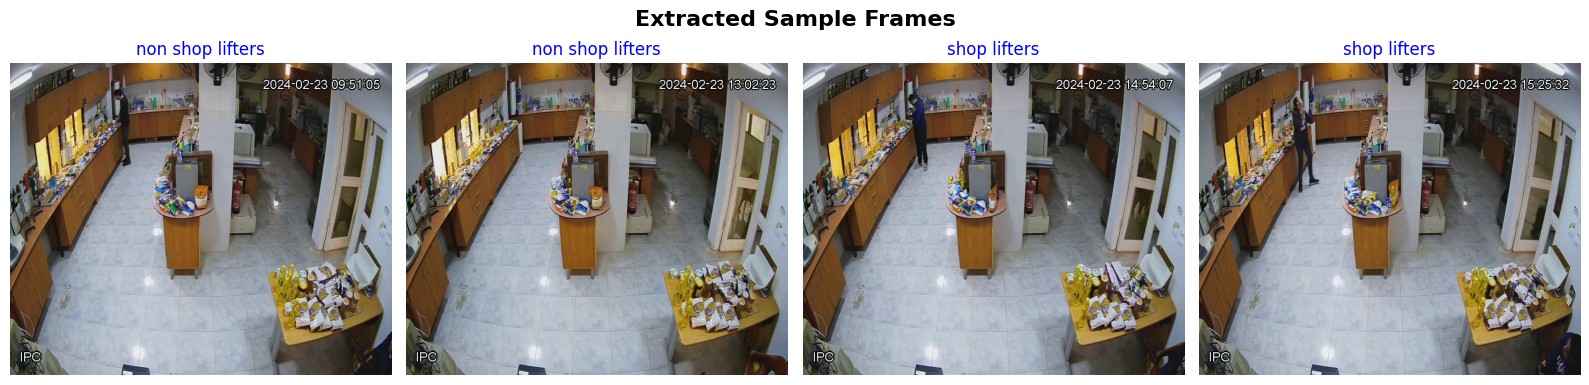

In [ ]:
console.rule("[bold yellow]📸 Extracting Frames[/bold yellow]")
extract_sample_frames(video_dict)

In [ ]:
console.rule("[bold yellow]📈 Generating Visualizations[/bold yellow]")
plot_class_distribution(df)
plot_duration_distribution(df)
console.print(Panel.fit(f"All analysis & visuals saved → {OUTPUT_DIR}", style="bold green"))

────────────────────────────────────────── 📈 Generating Visualizations ───────────────────────────────────────────

╭──────────────────────────────────────────────────────────────────────────────────╮
│ All analysis & visuals saved → /content/drive/MyDrive/Cellula/03_Project3/Output │
╰──────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
def get_video_dict(data_dir, classes):
    """Map each class to its videos."""
    video_dict = {}
    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        video_list = [os.path.join(cls_path, v) for v in os.listdir(cls_path) if v.endswith((".mp4", ".avi", ".mov"))]
        video_dict[cls] = video_list
    return video_dict

In [ ]:
def summarize_videos(video_dict):
    """Print summary of dataset using Rich."""
    table = Table(title="📊 Video Dataset Summary", title_style="bold cyan")
    table.add_column("Class", justify="center", style="bold green")
    table.add_column("Count", justify="center", style="yellow")
    table.add_column("Total Duration (sec)", justify="center", style="magenta")
    table.add_column("Resolution", justify="center", style="cyan")

    for cls, videos in video_dict.items():
        durations = []
        resolutions = set()
        for v in videos:
            cap = cv2.VideoCapture(v)
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            durations.append(frame_count / fps if fps > 0 else 0)
            resolutions.add(f"{int(cap.get(3))}x{int(cap.get(4))}")
            cap.release()
        table.add_row(cls, str(len(videos)), f"{np.mean(durations):.2f}±{np.std(durations):.2f}", ", ".join(resolutions))
    console.print(table)


In [ ]:
def extract_clips_from_video(video_path, output_dir, clip_length=16, stride=8, resize=(224, 224)):
    """Split a video into fixed-length clips and save as individual frame folders."""
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    clip_paths = []
    clip_index = 0

    for start in range(0, total_frames - clip_length, stride):
        clip_folder = os.path.join(output_dir, f"clip_{clip_index}")
        os.makedirs(clip_folder, exist_ok=True)
        for i in range(clip_length):
            cap.set(cv2.CAP_PROP_POS_FRAMES, start + i)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, resize)
            cv2.imwrite(os.path.join(clip_folder, f"frame_{i}.jpg"), frame)
        clip_paths.append(clip_folder)
        clip_index += 1

    cap.release()
    return clip_paths, fps, total_frames

In [ ]:
def process_dataset_to_clips(video_dict, clip_length=16, stride=8):
    """Convert all dataset videos to clips and generate metadata CSV."""
    metadata = []
    console.rule("[bold yellow]📦 Dataset → Clip Conversion Started[/bold yellow]")

    for label, videos in video_dict.items():
        label_dir = os.path.join(CLIP_DIR, label.replace(" ", "_"))
        os.makedirs(label_dir, exist_ok=True)
        for video_path in tqdm(videos, desc=f"Processing {label}"):
            clips, fps, total_frames = extract_clips_from_video(
                video_path, label_dir, clip_length, stride
            )
            for clip_path in clips:
                metadata.append({
                    "class": label,
                    "video": os.path.basename(video_path),
                    "clip_path": clip_path,
                    "fps": fps,
                    "frames_in_video": total_frames,
                    "frames_in_clip": clip_length
                })

    meta_df = pd.DataFrame(metadata)
    meta_csv = os.path.join(CLIP_DIR, "metadata.csv")
    meta_df.to_csv(meta_csv, index=False)
    console.print(Panel.fit(f"Metadata saved → {meta_csv}", style="bold green"))
    return meta_df

In [ ]:
def visualize_sample_clip(clip_path):
    """Visualize one sample clip as a concatenated image using Plotly."""
    frames = sorted([os.path.join(clip_path, f) for f in os.listdir(clip_path)])
    sample = frames[:min(9, len(frames))]
    imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in sample]

    fig = px.imshow(np.concatenate(imgs, axis=1))
    fig.update_layout(
        title=dict(text=f"🎞 Sample Clip Preview → {os.path.basename(clip_path)}", x=0.5, font=dict(size=22, color="cyan")),
        template="plotly_dark"
    )
    fig.show()

In [ ]:
def save_dataset_npz(metadata_df, save_path, batch_size=1000):
    """
    Convert clips to NumPy arrays and save them in chunks to avoid RAM overflow.
    Each chunk is saved as a separate NPZ file: dataset_part_0.npz, dataset_part_1.npz, ...
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    total = len(metadata_df)
    num_batches = (total + batch_size - 1) // batch_size

    console.rule("[bold yellow]💾 Saving Dataset to NPZ in Chunks[/bold yellow]")
    for batch_idx in range(num_batches):
        start = batch_idx * batch_size
        end = min(start + batch_size, total)
        batch_df = metadata_df.iloc[start:end]

        X, Y = [], []
        for _, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Batch {batch_idx+1}/{num_batches}"):
            frames = sorted([os.path.join(row.clip_path, f) for f in os.listdir(row.clip_path)])
            imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in frames]
            X.append(np.array(imgs, dtype=np.uint8))  # clip array
            Y.append(0 if row["class"] == "non shop lifters" else 1)

        batch_path = f"{os.path.splitext(save_path)[0]}_part_{batch_idx}.npz"
        np.savez_compressed(batch_path, X=np.array(X), Y=np.array(Y))
        console.print(Panel.fit(f"Saved batch {batch_idx+1}/{num_batches} → {batch_path}", style="bold green"))

        # Free memory for next batch
        del X, Y

    console.print(Panel.fit(f"All batches saved in folder → {os.path.dirname(save_path)}", style="bold cyan"))

                    📊 Video Dataset Summary                    
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃      Class       ┃ Count ┃ Total Duration (sec) ┃ Resolution ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ non shop lifters │  531  │      13.93±5.36      │  704x576   │
│   shop lifters   │  324  │      12.22±3.35      │  704x576   │
└──────────────────┴───────┴──────────────────────┴────────────┘

─────────────────────────────────────────── 📸 Extracting Sample Frames ───────────────────────────────────────────

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/non_shop_lifters_0.jpg

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/non_shop_lifters_1.jpg

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/shop_lifters_0.jpg

Saved sample frame → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames/shop_lifters_1.jpg

╭───────────────────────────────────────────────────────────────────────────────────╮
│ Frames saved in → /content/drive/MyDrive/Cellula/03_Project3/Output/sample_frames │
╰───────────────────────────────────────────────────────────────────────────────────╯

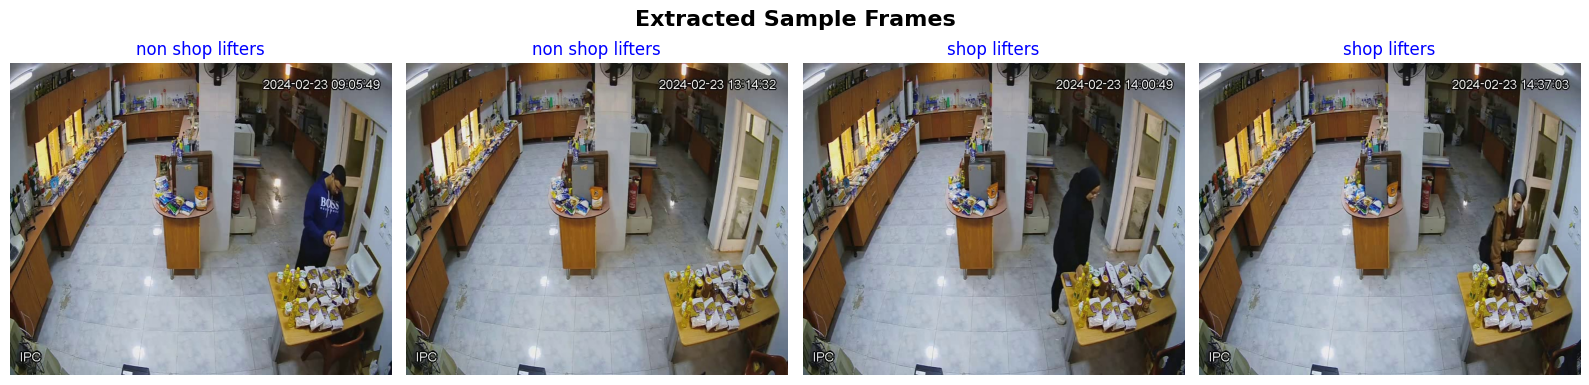

────────────────────────────────────── 📦 Dataset → Clip Conversion Started ───────────────────────────────────────

Processing shop lifters: 100%|██████████| 324/324 [35:45<00:00,  6.62s/it]


╭───────────────────────────────────────────────────────────────────────────────────────╮
│ Metadata saved → /content/drive/MyDrive/Cellula/03_Project3/Output/clips/metadata.csv │
╰───────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
video_dict = get_video_dict(DATA_DIR, CLASSES)
summarize_videos(video_dict)
extract_sample_frames(video_dict)
metadata_df = process_dataset_to_clips(video_dict, clip_length=6, stride=30)

In [ ]:
# Visualize random clip
random_clip = random.choice(metadata_df["clip_path"].tolist())
visualize_sample_clip(random_clip)

In [ ]:
# Save NPZ
save_dataset_npz(metadata_df, os.path.join(NPZ_DIR, "video_dataset.npz"))

─────────────────────────────────────── 💾 Saving Dataset to NPZ in Chunks ────────────────────────────────────────

Batch 1/10: 100%|██████████| 1000/1000 [00:51<00:00, 19.47it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 1/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_0.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 2/10: 100%|██████████| 1000/1000 [00:50<00:00, 19.95it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 2/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_1.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 3/10: 100%|██████████| 1000/1000 [00:51<00:00, 19.29it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 3/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_2.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 4/10: 100%|██████████| 1000/1000 [00:50<00:00, 19.67it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 4/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_3.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 5/10: 100%|██████████| 1000/1000 [00:50<00:00, 19.93it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 5/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_4.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 6/10: 100%|██████████| 1000/1000 [00:51<00:00, 19.56it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 6/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_5.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 7/10: 100%|██████████| 1000/1000 [00:57<00:00, 17.41it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 7/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_6.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 8/10: 100%|██████████| 1000/1000 [00:50<00:00, 19.85it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 8/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_7.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 9/10: 100%|██████████| 1000/1000 [00:50<00:00, 19.91it/s]


╭───────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 9/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_8.npz │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

Batch 10/10: 100%|██████████| 683/683 [00:35<00:00, 19.23it/s]


╭────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Saved batch 10/10 → /content/drive/MyDrive/Cellula/03_Project3/Output/npz/video_dataset_part_9.npz │
╰────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────╮
│ All batches saved in folder → /content/drive/MyDrive/Cellula/03_Project3/Output/npz │
╰─────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
# =============================
# Hyperparameters
# =============================
FRAMES_PER_VIDEO = 16        # Reduced for tuning, matches target_clip_len
FRAME_SIZE = (64, 64)       # Smaller size for tuning
BATCH_SIZE = 4              # Reduce batch size
EPOCHS = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
console.print(Panel(f"Using device: [bold yellow]{DEVICE}[/bold yellow]", style="bold green"))

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Using device: cpu                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
# =============================
# Dataset for Chunked NPZ Files (Memory Optimized)
# =============================
class ChunkedNPZDataset(Dataset):
    """
    Dataset class to handle multiple chunked NPZ files.
    Each NPZ file must contain arrays 'X' (frames) and 'Y' (labels).
    """

    def __init__(self, npz_dir, transform=None, target_clip_len=16):
        self.npz_files = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
        if not self.npz_files:
            raise FileNotFoundError(f"No NPZ files found in {npz_dir}")

        self.transform = transform
        self.target_clip_len = target_clip_len
        self.samples = []
        self._load_metadata()

    def _load_metadata(self):
        console.print(Panel("Indexing samples from NPZ files...", style="bold blue"))
        offset = 0
        for npz_path in self.npz_files:
            with np.load(npz_path, allow_pickle=True) as data:
                length = len(data["X"])
                for i in range(length):
                    self.samples.append((npz_path, i, offset + i))
            offset += length
        console.print(Panel(f"Total samples indexed: {len(self.samples)}", style="bold green"))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        npz_path, local_idx, _ = self.samples[idx]
        # Lazy load only one sample
        with np.load(npz_path, allow_pickle=True) as data:
            frames = data["X"][local_idx]
            label = data["Y"][local_idx]

        # Convert to torch tensor
        frames = torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.0

        # Apply transforms if provided
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames], dim=0)

        # Adjust clip length
        frames = fix_clip_length(frames, self.target_clip_len)
        return frames, torch.tensor(label, dtype=torch.long)

In [ ]:

# =============================
# Transformations
# =============================
transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(10),
    T.Resize(FRAME_SIZE),
    T.ToTensor()
])

In [ ]:
# =============================
# Create Dataset and Split
# =============================
# dataset_path = "/kaggle/working/output/npz"  # path where dataset_part_*.npz files are stored
dataset = ChunkedNPZDataset(NPZ_DIR, transform=transform)

# Split dataset: 70% train, 15% val, 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

console.print(Panel(f"Train samples: {len(train_ds)} | "
                    f"Val samples: {len(val_ds)} | "
                    f"Test samples: {len(test_ds)}", style="bold cyan"))

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Indexing samples from NPZ files...                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Total samples indexed: 9683                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Train samples: 6778 | Val samples: 1452 | Test samples: 1453                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
# =============================
# Utility for clip length
# =============================
def fix_clip_length(clip, target_len=16):
    if clip.size(0) > target_len:
        return clip[:target_len]
    elif clip.size(0) < target_len:
        pad = target_len - clip.size(0)
        last_frame = clip[-1].unsqueeze(0).repeat(pad, 1, 1, 1)
        return torch.cat([clip, last_frame], dim=0)
    return clip

In [ ]:
# =============================
# Example: Iterate one batch
# =============================
for frames, labels in train_loader:
    console.print(f"Batch frames shape: {frames.shape}")  # (B, T, C, H, W)
    console.print(f"Batch labels shape: {labels.shape}")
    break

Batch frames shape: torch.Size([4, 16, 3, 64, 64])

Batch labels shape: torch.Size([4])

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

In [ ]:
class AdvancedC3D(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=1), nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=1), nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1), nn.ReLU(),
            nn.MaxPool3d((2, 2, 2))
        )

        # Dynamically calculate flatten dimension
        dummy_input = torch.zeros(1, 3, FRAMES_PER_VIDEO, FRAME_SIZE[0], FRAME_SIZE[1])
        with torch.no_grad():
            out = self.features(dummy_input)
        flatten_dim = out.numel()

        self.classifier = nn.Sequential(
            nn.Linear(flatten_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [ ]:
# =============================
# Model 2: CNN-LSTM (ResNet18 backbone)
# =============================
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2, hidden_size=256):
        super().__init__()
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()
        self.lstm = nn.LSTM(512, hidden_size, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.view(B * T, C, H, W)
        features = self.cnn(x)
        features = features.view(B, T, -1)
        out, _ = self.lstm(features)
        return self.fc(out[:, -1, :])

In [ ]:
# =============================
# Training & Evaluation
# =============================
def train_model(model, train_loader, val_loader, lr=1e-4, epochs=EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Fix clip length for each batch
            videos = torch.stack([fix_clip_length(v) for v in videos])
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos = torch.stack([fix_clip_length(v) for v in videos])
                videos, labels = videos.to(DEVICE), labels.to(DEVICE)
                outputs = model(videos)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        console.print(f"[yellow]Epoch {epoch+1}/{epochs}[/yellow] "
                      f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
                      f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), "best_model.pt")
    console.print(Panel.fit("Model weights saved to best_model.pt", style="bold green"))
    return history

In [ ]:
# =============================
# Plot Training History
# =============================
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title("Accuracy"); plt.legend()
    plt.show()

In [ ]:
def objective(trial):
    gc.collect()
    torch.cuda.empty_cache()

    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    model_choice = trial.suggest_categorical("model", ["C3D", "CNN-LSTM"])
    model = AdvancedC3D() if model_choice == "C3D" else CNNLSTM()

    # Subsample dataset
    small_train_ds, _ = random_split(train_ds, [len(train_ds)//5, len(train_ds)-len(train_ds)//5])
    small_val_ds, _ = random_split(val_ds, [len(val_ds)//5, len(val_ds)-len(val_ds)//5])
    small_train_loader = DataLoader(small_train_ds, batch_size=BATCH_SIZE, shuffle=True)
    small_val_loader = DataLoader(small_val_ds, batch_size=BATCH_SIZE)

    history = train_model(model, small_train_loader, small_val_loader, lr=lr, epochs=2)
    return max(history["val_acc"])


In [ ]:
# =============================
# Hyperparameter Optimization
# =============================
console.print(Panel.fit("Starting Optuna optimization...", style="bold blue"))
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=1)
console.print(Panel.fit(f"Best Trial: {study.best_trial.value:.4f}\nParams: {study.best_trial.params}",
                        style="bold magenta"))

In [ ]:
best_params = study.best_trial.params
model = AdvancedC3D() if best_params["model"] == "C3D" else CNNLSTM()
history = train_model(model, train_loader, val_loader, lr=best_params["lr"])
plot_history(history)

╭─────────────────────────────────╮
│ Starting Optuna optimization... │
╰─────────────────────────────────╯

[I 2025-08-05 10:54:07,607] A new study created in memory with name: no-name-5e848683-082b-4116-92bd-a0bb908507d2
/tmp/ipython-input-784081717.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]
Epoch 1/2: 100%|██████████| 339/339 [4:05:51<00:00, 43.51s/it]


Epoch 1/2 Train Loss: 0.3296 | Val Loss: 0.1280 Train Acc: 0.8731 | Val Acc: 0.9690

Epoch 2/2:  35%|███▍      | 117/339 [1:26:16<2:43:25, 44.17s/it]

In [ ]:
def zip_folder(folder_path: str, output_path: str = None):
    """
    Zip an entire folder and make it ready for download (Kaggle-friendly).

    Args:
        folder_path (str): Path to the folder to be zipped.
        output_path (str, optional): Output zip file path.
                                      Defaults to folder_path+'.zip'.

    Returns:
        str: Path to the created zip file
    """
    folder_path = os.path.abspath(folder_path)
    if not os.path.isdir(folder_path):
        raise ValueError(f"Provided path '{folder_path}' is not a directory.")

    if output_path is None:
        output_path = folder_path.rstrip('/').rstrip('\\') + ".zip"

    # Collect all files
    files_to_zip = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            files_to_zip.append(os.path.join(root, file))

    console.print(Panel.fit(f"[bold green]Zipping folder:[/bold green] {folder_path}\n"
                            f"[bold cyan]Total files:[/bold cyan] {len(files_to_zip)}"))

    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file_path in tqdm(files_to_zip, desc="Compressing", colour="green", ncols=100):
            arcname = os.path.relpath(file_path, folder_path)
            zipf.write(file_path, arcname)

    console.print(Panel.fit(f"[bold yellow]Zip ready for download![/bold yellow]\n"
                            f"[bold cyan]{output_path}[/bold cyan]"))

    return output_path

In [ ]:
zip_folder("/content/drive/MyDrive/Cellula/03_Project3/Output")

╭────────────────────────────────────────╮
│ Zipping folder: /kaggle/working/output │
│ Total files: 884                       │
╰────────────────────────────────────────╯

Compressing:  93%|████████████████████████████████████████████▌   | 820/884 [04:09<00:19,  3.28it/s]


OSError: [Errno 28] No space left on device

In [ ]:
# =============================
# Create Dataset and Split
# =============================
# dataset_path = "/kaggle/working/output/npz"  # path where dataset_part_*.npz files are stored
dataset = ChunkedNPZDataset(NPZ_DIR, transform=transform)

# Split dataset: 70% train, 15% val, 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

console.print(Panel(f"Train samples: {len(train_ds)} | "
                    f"Val samples: {len(val_ds)} | "
                    f"Test samples: {len(test_ds)}", style="bold cyan"))

In [ ]:
# Train Best Model
best_params = study.best_trial.params
if best_params["model"] == "C3D":
    model = AdvancedC3D()
else:
    model = CNNLSTM()

history = train_model(model, train_loader, val_loader, lr=best_params["lr"])
plot_history(history)